In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [30]:
data1 = pd.read_csv('DataSet.csv')
data2 = pd.read_csv('DataSetfinal.csv')
data1.head(5)

,Voltage_RMS,Voltage_Mean,Voltage_Peak_Value,Voltage_ShapeFactor,Duty_Peak_Value,Duty_RMS,Duty_Mean,Duty_ShapeFactor,Duty_Clearance_factor,Ilf_Mean
0,140.066695,140.064692,142.098841,1.000014,0.406643,0.400259,0.400253,1.000014,1.015950,70.372059
1,140.102590,140.102044,140.979457,1.000004,0.404295,0.391036,0.390550,1.001243,1.033908,56.311013
2,140.102709,140.102163,141.021557,1.000004,0.404372,0.390926,0.390429,1.001273,1.034394,46.920518
3,140.105313,140.104762,140.969868,1.000004,0.404298,0.390953,0.390459,1.001267,1.034134,40.222416
4,140.103499,140.102951,140.965729,1.000004,0.404417,0.390975,0.390483,1.001259,1.034383,35.187581


In [31]:
data2.head(5)

,Voltage_RMS,Voltage_Mean,Voltage_Peak_Value,Voltage_ShapeFactor,Duty_Peak_Value,Duty_RMS,Duty_Mean,Duty_ShapeFactor,Duty_Clearance_factor,Ilf_Mean
0,140.191334,139.958256,142.071728,0.960808,0.364180,0.519955,0.321555,1.092337,0.952003,70.369667
1,140.162998,140.123925,141.034213,1.110356,0.478335,0.388129,0.370067,0.938765,1.061718,56.460836
2,139.968841,140.159851,140.968889,0.965515,0.424221,0.483292,0.431316,0.975224,1.028542,46.846165
3,140.196156,140.193562,140.883053,0.982582,0.375275,0.304300,0.367179,0.873125,1.150290,40.319712
4,140.216028,140.127517,141.004064,1.077311,0.355307,0.501868,0.382286,0.975169,0.938164,35.216965


In [24]:
# Load and preprocess the data
def preprocess_data(df):
    # Remove outliers using IQR method
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Feature engineering
    df['Voltage_RMS_to_Mean_Ratio'] = df['Voltage_RMS'] / df['Voltage_Mean']
    df['Duty_RMS_to_Mean_Ratio'] = df['Duty_RMS'] / df['Duty_Mean']
    df['Voltage_Duty_Interaction'] = df['Voltage_Mean'] * df['Duty_Mean']
    # df['Power_Feature'] = df['Voltage_Mean'] * df['Ilf_Mean']

    # Calculate derivatives
    df['Voltage_RMS_derivative'] = np.gradient(df['Voltage_RMS'])
    df['Duty_RMS_derivative'] = np.gradient(df['Duty_RMS'])

    # Normalize data
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Create time-based features
    df_scaled['time'] = np.arange(len(df_scaled))
    df_scaled['sin_time'] = np.sin(2 * np.pi * df_scaled['time'] / len(df_scaled))
    df_scaled['cos_time'] = np.cos(2 * np.pi * df_scaled['time'] / len(df_scaled))

    return df_scaled



In [25]:
# Load the data
data = pd.read_csv('DataSet.csv')
preprocessed_data = preprocess_data(data)
preprocessed_data.head(5)
preprocessed_data.to_csv('preprocessed_data.csv', index=False)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13500\4208460008.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Voltage_RMS_to_Mean_Ratio'] = df['Voltage_RMS'] / df['Voltage_Mean']
C:\Users\Asus\AppData\Local\Temp\ipykernel_13500\4208460008.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Duty_RMS_to_Mean_Ratio'] = df['Duty_RMS'] / df['Duty_Mean']
C:\Users\Asus\AppData\Local\Temp\ipykernel_13500\4208460008.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [26]:
# Split features and target
X = preprocessed_data.drop('Ilf_Mean', axis=1)
y = preprocessed_data['Ilf_Mean']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

Mean Squared Error: 0.0038108915087485553
R-squared Score: 0.9249125908142709


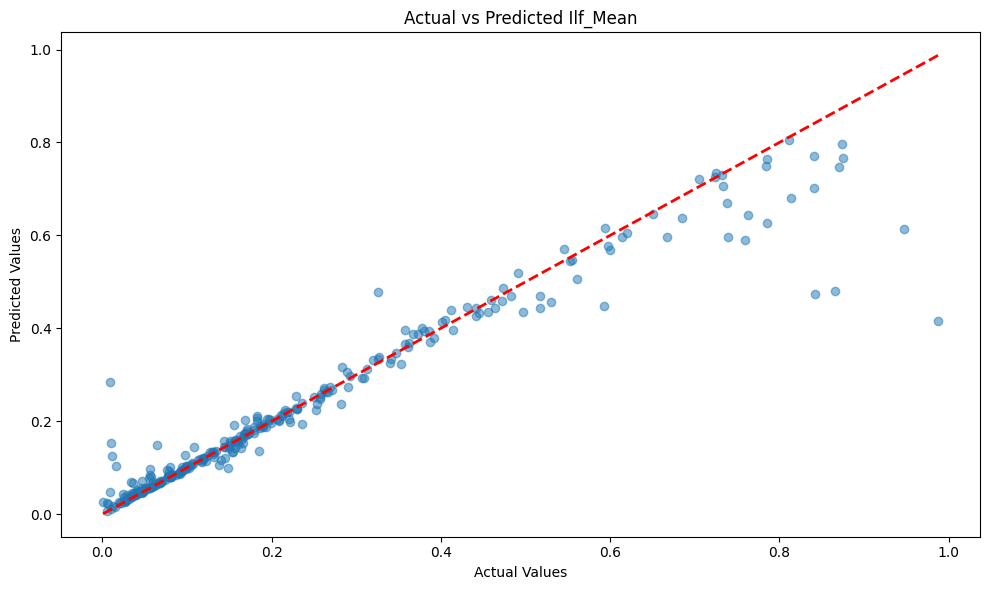

In [22]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ilf_Mean')
plt.tight_layout()
plt.show()